<a href="https://colab.research.google.com/github/pushkar-khetrapal/EfficientPS/blob/master/Copy_of_Coco_mask_R_CNNwithUpdatedBackbone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-7e66nqo_
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-7e66nqo_
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=266454 sha256=69470b4d57701ace952391bed0cd3191d852c762bb63fbd39b4cc4d2a9dc4b72
  Stored in directory: /tmp/pip-ephem-wheel-cache-qa_7ccbd/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0


In [ ]:
import os
import urllib
import shutil
import zipfile
def auto_download(dataDir, dataType, dataYear):
    """Download the COCO dataset/annotations if requested.
    dataDir: The root directory of the COCO dataset.
    dataType: What to load (train, val, minival, valminusminival)
    dataYear: What dataset year to load (2014, 2017) as a string, not an integer
    Note:
        For 2014, use "train", "val", "minival", or "valminusminival"
        For 2017, only "train" and "val" annotations are available
    """

    # Setup paths and file names
    if dataType == "minival" or dataType == "valminusminival":
        imgDir = "{}/{}{}".format(dataDir, "val", dataYear)
        imgZipFile = "{}/{}{}.zip".format(dataDir, "val", dataYear)
        imgURL = "http://images.cocodataset.org/zips/{}{}.zip".format("val", dataYear)
    else:
        imgDir = "{}/{}{}".format(dataDir, dataType, dataYear)
        imgZipFile = "{}/{}{}.zip".format(dataDir, dataType, dataYear)
        imgURL = "http://images.cocodataset.org/zips/{}{}.zip".format(dataType, dataYear)
    # print("Image paths:"); print(imgDir); print(imgZipFile); print(imgURL)

    # Create main folder if it doesn't exist yet
    if not os.path.exists(dataDir):
        os.makedirs(dataDir)

    # Download images if not available locally
    if not os.path.exists(imgDir):
        os.makedirs(imgDir)
        print("Downloading images to " + imgZipFile + " ...")
        with urllib.request.urlopen(imgURL) as resp, open(imgZipFile, 'wb') as out:
            shutil.copyfileobj(resp, out)
        print("... done downloading.")
        print("Unzipping " + imgZipFile)
        with zipfile.ZipFile(imgZipFile, "r") as zip_ref:
            zip_ref.extractall(dataDir)
        print("... done unzipping")
    print("Will use images in " + imgDir)

    # Setup annotations data paths
    annDir = "{}/annotations".format(dataDir)
    if dataType == "minival":
        annZipFile = "{}/instances_minival2014.json.zip".format(dataDir)
        annFile = "{}/instances_minival2014.json".format(annDir)
        annURL = "https://dl.dropboxusercontent.com/s/o43o90bna78omob/instances_minival2014.json.zip?dl=0"
        unZipDir = annDir
    elif dataType == "valminusminival":
        annZipFile = "{}/instances_valminusminival2014.json.zip".format(dataDir)
        annFile = "{}/instances_valminusminival2014.json".format(annDir)
        annURL = "https://dl.dropboxusercontent.com/s/s3tw5zcg7395368/instances_valminusminival2014.json.zip?dl=0"
        unZipDir = annDir
    else:
        annZipFile = "{}/annotations_trainval{}.zip".format(dataDir, dataYear)
        annFile = "{}/instances_{}{}.json".format(annDir, dataType, dataYear)
        annURL = "http://images.cocodataset.org/annotations/annotations_trainval{}.zip".format(dataYear)
        unZipDir = dataDir
    # print("Annotations paths:"); print(annDir); print(annFile); print(annZipFile); print(annURL)

    # Download annotations if not available locally
    if not os.path.exists(annDir):
        os.makedirs(annDir)
    if not os.path.exists(annFile):
        if not os.path.exists(annZipFile):
            print("Downloading zipped annotations to " + annZipFile + " ...")
            with urllib.request.urlopen(annURL) as resp, open(annZipFile, 'wb') as out:
                shutil.copyfileobj(resp, out)
            print("... done downloading.")
        print("Unzipping " + annZipFile)
        with zipfile.ZipFile(annZipFile, "r") as zip_ref:
            zip_ref.extractall(unZipDir)
        print("... done unzipping")
    print("Will use annotations in " + annFile)

In [ ]:
auto_download('/datasets01/COCO/022719/', 'train','2017')
auto_download('/datasets01/COCO/022719/', 'val','2017')

... done downloading.
Unzipping /content/dataset/val2017.zip
... done unzipping
Will use images in /content/dataset/val2017
Will use annotations in /content/dataset/annotations/instances_val2017.json


In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image

In [ ]:
%%shell

pip install efficientnet_pytorch
pip install git+https://github.com/mapillary/inplace_abn
pip install torch-summary

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12422 sha256=a615e808b81dc5af65e1d2b4ab245c12a2caa329f90a5d42aecc076b857ad9a5
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built efficientnet-pytorch
  Cloning https://github.com/mapillary/inplace_abn to /tmp/pip-req-build-lpjtlq3q
  Running command git clone -q https://github.com/mapillary/inplace_abn /tmp/pip-req-build-lpjtlq3q
  Created wheel for inplace-abn: filename=inplace_abn-1.0.12-cp36-cp36m-linux_x86_64.whl size=3269311 sha256=aa6212c5ce3f79d4fd45889f35018bde054b89b46ad97131ba16098d2a8d9f16
  Stored in directory: /tmp/pip-ephem-wheel-cache-0babvugm/wheels/fe/0b/49/1303ca37166cc1be8784e2367a172133634dcd864a9df0ab56
Successfully built inplace-abn


In [ ]:
!git clone https://github.com/pushkar-khetrapal/EfficientPS.git

Cloning into 'EfficientPS'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 54 (delta 30), reused 54 (delta 30), pack-reused 0
Unpacking objects: 100% (54/54), done.


In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../
cp references/detection/train.py ../
cp references/detection/group_by_aspect_ratio.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be37608 version check against PyTorch's CUDA version


In [ ]:
%%shell

python -m torch.distributed.launch --nproc_per_node=1 --use_env train.py\
    --dataset coco --model maskrcnn_resnet50_fpn --epochs 26\
    --lr-steps 16 22 --aspect-ratio-group-factor 3 --data-path='/content/dataset'

| distributed init (rank 0): env://
Namespace(aspect_ratio_group_factor=3, batch_size=2, data_path='/content/dataset', dataset='coco', device='cuda', dist_backend='nccl', dist_url='env://', distributed=True, epochs=26, gpu=0, lr=0.02, lr_gamma=0.1, lr_step_size=8, lr_steps=[16, 22], model='maskrcnn_resnet50_fpn', momentum=0.9, output_dir='.', pretrained=False, print_freq=20, rank=0, resume='', test_only=False, weight_decay=0.0001, workers=4, world_size=1)
Loading data
loading annotations into memory...
Done (t=14.72s)
creating index...
index created!
loading annotations into memory...
Done (t=1.02s)
creating index...
index created!
Creating data loaders
Using [0, 0.5, 0.6299605249474366, 0.7937005259840997, 1.0, 1.2599210498948732, 1.5874010519681994, 2.0, inf] as bins for aspect ratio quantization
Count of instances per bin: [ 1072  5849 74466  3921  6636 24236   978   108]
Creating model
Loaded pretrained weights for efficientnet-b5
Start training
/usr/local/lib/python3.6/dist-packag

In [ ]:
from EfficientPS.PretrainedBackbone import TwoWayFPNBackbone

Loaded pretrained weights for efficientnet-b5


In [ ]:
import torchvision
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNN

In [ ]:
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    #model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    backbone = TwoWayFPNBackbone()
    model = MaskRCNN(backbone, num_classes)
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be37608 version check against PyTorch's CUDA version




Let's write some helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that we have just copied:


In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

Now let's instantiate the model and the optimizer

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
model

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): FPN(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): InPlaceABN(48, eps=1e-05, momentum=0.1, affine=True, activation=leaky_relu[0.01])
    (blocks0): Sequential(
      (0): Sequential(
        (0): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (1): InPlaceABN(48, eps=1e-05, momentum=0.1, affine=True, activation=leaky_relu[0.01])
        (2): Conv2dStaticSamePadding(
          48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False
          (static_padding): Identity()
        )
        (3): InPlaceABN(24, eps=1e

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

41148043

And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [ ]:
# let's train it for 10 epochs
num_epochs = 100

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Ten

Epoch: [0]  [ 0/60]  eta: 0:01:47  lr: 0.000090  loss: 4.1502 (4.1502)  loss_classifier: 0.8491 (0.8491)  loss_box_reg: 0.0046 (0.0046)  loss_mask: 2.5705 (2.5705)  loss_objectness: 0.6933 (0.6933)  loss_rpn_box_reg: 0.0327 (0.0327)  time: 1.7843  data: 0.2522  max mem: 9022
Epoch: [0]  [10/60]  eta: 0:00:56  lr: 0.000936  loss: 3.6494 (4.3587)  loss_classifier: 0.6368 (0.5926)  loss_box_reg: 0.0254 (0.0239)  loss_mask: 2.0908 (3.0269)  loss_objectness: 0.6931 (0.6928)  loss_rpn_box_reg: 0.0223 (0.0225)  time: 1.1299  data: 0.0302  max mem: 9022
Epoch: [0]  [20/60]  eta: 0:00:44  lr: 0.001783  loss: 1.9463 (3.1065)  loss_classifier: 0.1863 (0.3566)  loss_box_reg: 0.0279 (0.0265)  loss_mask: 1.0547 (2.0141)  loss_objectness: 0.6915 (0.6907)  loss_rpn_box_reg: 0.0144 (0.0185)  time: 1.0686  data: 0.0075  max mem: 9022
Epoch: [0]  [30/60]  eta: 0:00:33  lr: 0.002629  loss: 1.6691 (2.6551)  loss_classifier: 0.0867 (0.2704)  loss_box_reg: 0.0281 (0.0270)  loss_mask: 0.8815 (1.6518)  loss_ob

Now that training has finished, let's have a look at what it actually predicts in a test image

In [ ]:
# pick one image from the test set
img, _ = dataset_test[10]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [ ]:
prediction[0]['masks'].shape

torch.Size([24, 1, 411, 504])

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

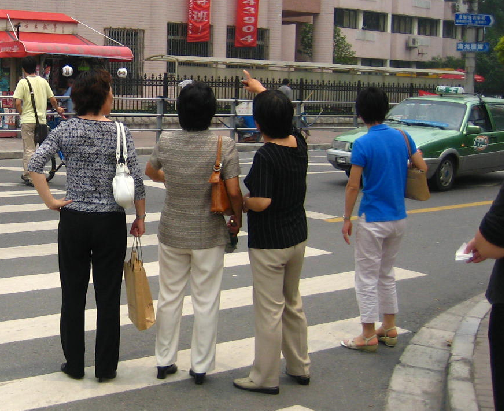

In [ ]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

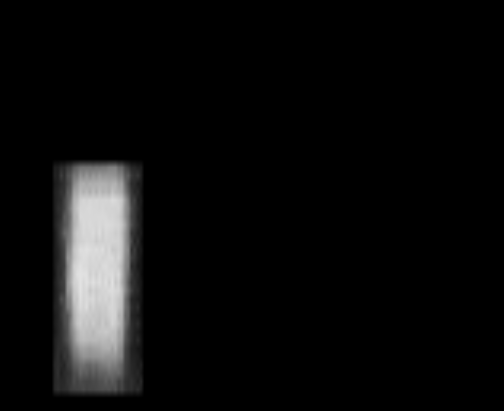

In [ ]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

In [ ]:
a = img.mul(255).permute(1, 2, 0).byte().numpy()

In [ ]:
b = prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy()

In [ ]:
z = prediction[0]['boxes'][0].byte().cpu().numpy()

In [ ]:
import cv2

In [ ]:
z

array([ 53, 164, 141, 137], dtype=uint8)

In [ ]:
rect = cv2.rectangle(a,(z[0],z[1]),(z[0]+z[2],z[1]+z[3]),(255,255,255),10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in ubyte_scalars
  """Entry point for launching an IPython kernel.


In [ ]:
color = (0, 0, 0) 
thickness = -1
image = cv2.rectangle(a, (z[0],z[1]), (z[0]+z[2],z[1]+z[3]), color, thickness)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in ubyte_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
image

<UMat 0x7fd440042810>

In [ ]:
z1 = a[:,:,0] * b
z2 = a[:,:,1] * b
z3 = a[:,:,2] * b

In [ ]:
z1 = z1.reshape((411,504,1))
z2 = z2.reshape((411,504,1))
z3 = z3.reshape((411,504,1))


In [ ]:
z = np.concatenate((z1,z2,z3), axis=2)

In [ ]:
z.shape

(411, 504, 3)

In [ ]:
Image.fromarray(rect)

AttributeError: ignored

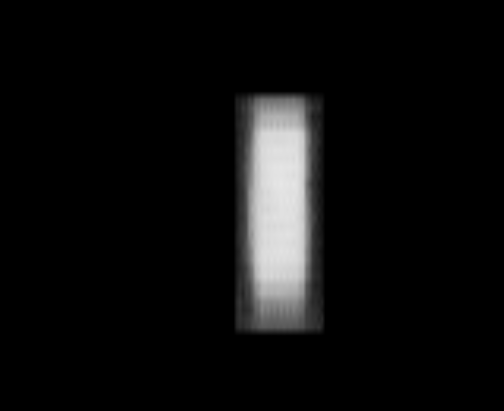

In [ ]:
Image.fromarray(prediction[0]['masks'][1, 0].mul(255).byte().cpu().numpy())

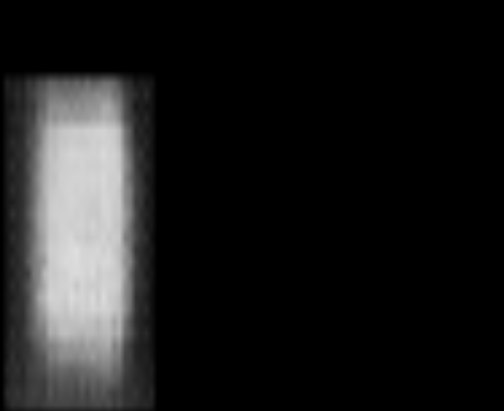

In [ ]:
Image.fromarray(prediction[0]['masks'][2, 0].mul(255).byte().cpu().numpy())

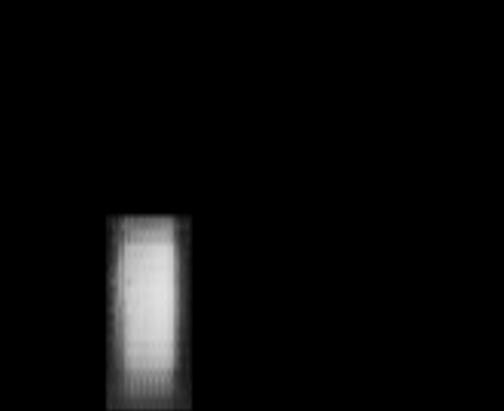

In [ ]:
Image.fromarray(prediction[0]['masks'][5, 0].mul(255).byte().cpu().numpy())

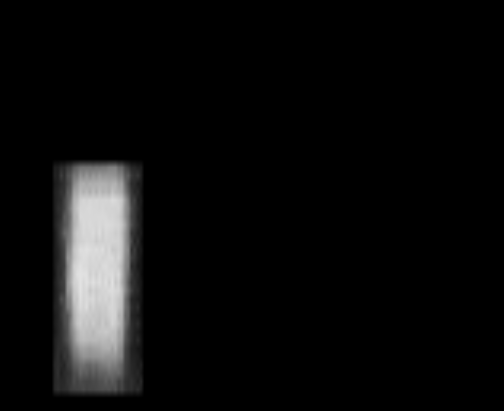

In [ ]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())